Imports & Methods

In [1]:
from node import Node
from pubsub import pub
from dag_blockchain import DAGBlockchain
import csv
from copy import deepcopy
from blockchain_utils import BlockchainUtils
import block
from pubsub import pub
from node import Node
from transaction import Transaction
from sensor_transaction import SensorTransaction
from transaction_pool import TransactionPool
from wallet import Wallet
from Crypto.PublicKey import RSA
import pprint
import random
import time
from cluster import Cluster
import copy
import json
import sys
import re
import random

def move_listener(listener, oldtopic, newtopic):
    pub.unsubscribe(listener, oldtopic)
    pub.subscribe(listener, newtopic)

def create_clusters(new_nodes):
    beg2 = time.time()
    for j in range(16):
        new_cluster = Cluster(j + 1, 0)
        genesis_node_id = j + 1
        new_genesis_forger = new_nodes[j].wallet.public_key_string()
        dag_blockchain = DAGBlockchain(4, genesis_node_id, new_genesis_forger, j+1)
        new_cluster.blockchain = dag_blockchain
        clusters.append(new_cluster)
    print(f'time to initialize {len(clusters)} clusters: {time.time() - beg2} seconds')

Initializing 80 nodes from data file

In [2]:
nodes = []
nodes_start = time.time()
i = 0

extra_results = open(f'extra_results.csv', mode='w')
with open('./extra_data.txt') as f:
    lines = f.readlines()  # list containing lines of file
    for line in lines[:80]:
        parts = line.split(',')
        new_node = Node(0, i + 1, int(parts[5].strip()))
        new_node.coords = [float(parts[2].strip()), float(parts[3].strip())]
        nodes.append(new_node)
        i += 1

print(f'time to initialize {len(nodes)} nodes: {time.time() - nodes_start} seconds')

time to initialize 80 nodes: 127.85870289802551 seconds


Initializing 16 clusters and assigning blockchains to each

In [32]:
clusters = []
cluster_start = time.time()
create_clusters(nodes)

time to initialize 16 clusters: 0.015395879745483398 seconds


Creating and adding blocks to each blockchain from simulation data

In [33]:
beg3 = time.time()
block_sum = 0
merge_sum = 0
create_sum = 0

i = 80
for line in lines[81:]:
    parts = line.split(',')
    cur_node = nodes[i % 80]
    cur_node.coords = [float(parts[2].strip()), float(parts[3].strip())]
    cur_node.cluster_id = int(parts[6].strip())

    create_start = time.time()
    genesis_forger = clusters[cur_node.cluster_id - 1].blockchain.genesis_forger
    new_block = block.Block([], i + 2, int(cur_node.coords[0]),
                            int(cur_node.coords[1]), genesis_forger)
    new_block.cluster_id = cur_node.cluster_id
    create_end = time.time() - create_start
    create_sum += create_end
    
    block_start = time.time()
    clusters[cur_node.cluster_id - 1].blockchain.add_block(new_block)

    block_end = time.time() - block_start
    block_sum += block_end

    # extra_blockchain = deepcopy(clusters[0].blockchain)
    # merge_start = time.time()
    # extra_blockchain.merge(clusters[cur_node.cluster_id - 1].blockchain)
    # merge_end = time.time() - merge_start
    # merge_sum += merge_end
    i += 1

print(f'total time spent adding 1000 blocks to 16 clusters: {time.time() - beg3} seconds')
print(f'average time to add a block to one of these cluster blockchains: {create_sum / i} seconds')
print(f'average time to add create a block: {block_sum / i} seconds')
# print(f'average time spent merging two blockchains: {merge_sum / i} seconds')

total time spent adding 1000 blocks to 16 clusters: 1.9647858142852783 seconds
average time to add a block to one of these cluster blockchains: 4.716316107766164e-06 seconds
average time to add create a block: 0.0018201135732726474 seconds


Merging

time to merge all cluster blockchains: 0.8607134819030762


KeyboardInterrupt: 

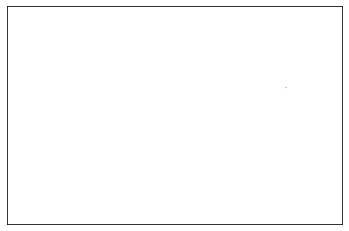

In [46]:
beg4 = time.time()
for k in range(14):
    clusters[0].blockchain.merge(clusters[k+1].blockchain)
print(f'time to merge all cluster blockchains: {time.time() - beg4}')

clusters[0].blockchain.visualize("")